In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_pickle('/content/drive/MyDrive/parsed_pdf.h5')

In [ ]:
reviews_df = pd.read_pickle('/content/drive/MyDrive/reviews_pdf.h5')

In [ ]:
merged_df = df.merge(reviews_df, left_on=['title', 'abstractText', 'accepted'], right_on=['title', 'abstractText', 'accepted'], how='outer')

In [ ]:
final_df = merged_df[merged_df['accepted'].notna()]
final_df = final_df[final_df['abstractText'].notna()]
final_df = final_df[final_df['title'].notna()]
del final_df['name']
del final_df['authors']
del final_df['creator']
del final_df['emails']
del final_df['referenceMentions']
del final_df['references']

In [ ]:
final_df["accepted"] = final_df["accepted"].astype(int)
final_df['accepted'].value_counts()

0    8188
1    7299
Name: accepted, dtype: int64

In [ ]:
final_df.isnull().sum(axis = 0)

abstractText         0
title                0
year             10942
 Introduction    11099
 Related Work    14053
 Experiments     13394
 Results         15116
 Conclusion      13423
 Discussion      14828
accepted             0
id                4545
reviews           4545
dtype: int64

In [ ]:
final_df.notna().sum(axis = 0)

abstractText     15487
title            15487
year              4545
 Introduction     4388
 Related Work     1434
 Experiments      2093
 Results           371
 Conclusion       2064
 Discussion        659
accepted         15487
id               10942
reviews          10942
dtype: int64

In [ ]:
final_df.head()

,abstractText,title,year,Introduction,Related Work,Experiments,Results,Conclusion,Discussion,accepted,id,reviews
0,"In self-supervised learning, a system is taske...",Self-Supervised Relational Reasoning for Repre...,0,Learning useful representations from unlabeled...,NaN,Evaluating self-supervised methods is problema...,NaN,NaN,NaN,1,NaN,NaN
1,"Graph neural networks (GNNs), which learn the ...",Towards Deeper Graph Neural Networks with Diff...,2020,"Graph neural networks (GNNs) [1, 2, 3] have em...",NaN,We now empirically evaluate the effectiveness ...,NaN,"In this paper, we propose two over-smoothing m...",NaN,1,NaN,NaN
2,Despite the recent success of Bayesian optimiz...,High-Dimensional Bayesian Optimization via Nes...,2020,Bayesian optimization (BO) is considered as a ...,NaN,"In this section, we evaluate the proposed HD-G...",NaN,"In this paper, we proposed HD-GaBO, a high-dim...",NaN,1,NaN,NaN
3,Exploration is a key problem in reinforcement ...,Effective Diversity in Population Based Reinfo...,2021,Reinforcement Learning (RL) considers the prob...,"Neuroevolution methods [56], seek to maximize ...",Here evaluate DvD-ES and DvD-TD3 in a variety ...,NaN,NaN,NaN,1,NaN,NaN
4,One paradigm for learning from few labeled exa...,Big Self-Supervised Models are Strong Semi-Sup...,2020,Learning from just a few labeled examples whil...,NaN,NaN,NaN,NaN,"In this work, we present a simple framework fo...",1,NaN,NaN


In [ ]:
final_df.drop(final_df.columns.difference(['abstractText','accepted']), 1, inplace=True)
final_df.head()

<ipython-input-10-e3511092354d>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  final_df.drop(final_df.columns.difference(['abstractText','accepted']), 1, inplace=True)


,abstractText,accepted
0,"In self-supervised learning, a system is taske...",1
1,"Graph neural networks (GNNs), which learn the ...",1
2,Despite the recent success of Bayesian optimiz...,1
3,Exploration is a key problem in reinforcement ...,1
4,One paradigm for learning from few labeled exa...,1


# FastText classification

In [ ]:
# !pip install fasttext

In [ ]:
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(final_df, test_size=0.2, random_state=42)

In [ ]:
# Create training and testing text files for FastText
train_file = "train.txt"
test_file = "test.txt"

In [ ]:
train_data[['accepted', 'abstractText']].to_csv(train_file, sep='\t', header=None, index=None)

In [ ]:
test_data[['accepted', 'abstractText']].to_csv(test_file, sep='\t', header=None, index=None)

In [ ]:
# Train FastText model
model = fasttext.train_supervised(input=train_file, epoch=10)

In [ ]:
# Train FastText model to get vectors
fasttext_model = fasttext.train_unsupervised(train_file, model='skipgram', dim=100, epoch=10)

In [ ]:
fasttext_model.save_model('/content/drive/MyDrive/fasttext_model.bin')

In [ ]:
# Create vectors for training data
X_train = [fasttext_model.get_sentence_vector(text) for text in train_data['abstractText']]

# Create vectors for testing data
X_test = [fasttext_model.get_sentence_vector(text) for text in test_data['abstractText']]

# SVM classifier

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train an SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, train_data['accepted'])

SVC(kernel='linear')

In [ ]:
# Make predictions on the test set
predictions = svm_classifier.predict(X_test)

In [ ]:
accuracy = accuracy_score(test_data['accepted'], predictions)
classification_rep = classification_report(test_data['accepted'], predictions)
conf_matrix = confusion_matrix(test_data['accepted'], predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.8389283408650743
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.98      0.87      1635
           1       0.97      0.68      0.80      1463

    accuracy                           0.84      3098
   macro avg       0.87      0.83      0.83      3098
weighted avg       0.87      0.84      0.83      3098

Confusion Matrix:
 [[1602   33]
 [ 466  997]]


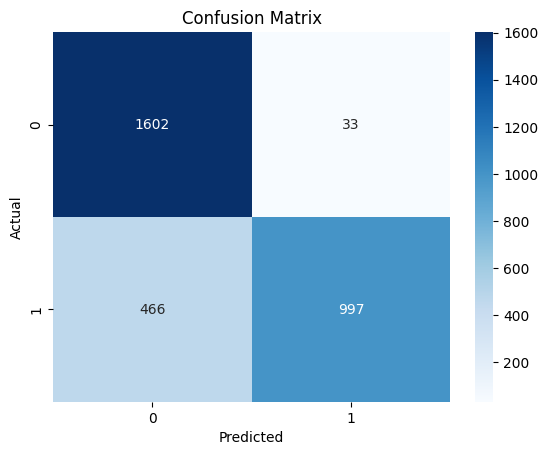

In [ ]:
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()